![Colegio Bourbaki](./Images/Bourbaki.png)

## Procesamiento de Lenguaje Natural

### Alocación latente de Dirichlet (Latent Dirichlet Allocation)

In [63]:
# Procesamiento y Visualizacion de Datos
import pandas as pd

#Plotting
import matplotlib.pyplot as plt

# Preprocesar texto
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Modelado de tópicos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

#Utils
from collections import Counter

In [64]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pdconte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
stopwords_nltk = stopwords.words("spanish")
len(stopwords_nltk)

313

In [66]:
stopwords = pd.read_csv(
    "https://gist.githubusercontent.com/cr0wg4n/78554c5d0afa9944d2fa3a4435d83a57/raw/df59fb916108f2a58bf1a3d8c62818b44231586d/spanish-stop-words.txt",
    header=None,
)
stopwords_list = stopwords[0].tolist()
len(stopwords_list)

608

### Funciones de ayuda

In [67]:
def generate_wordcloud(sequence):
    # Crear la cadena con la que haremos la nube de palabras
    text = " ".join(review for review in sequence)

    # Crear la nube de palabras
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        normalize_plurals=False,
        collocations=False,
    ).generate(text)

    # Desplegar la imagen generada
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [68]:
def preprocesar(text):
    # convierte a minúsculas
    text = text.lower()

    # elimina stopwords
    stop = re.compile(
        r"\b(" + r"|".join(stopwords_list) + r")\b\s*"
    )  # stopwords.words('spanish')
    text = stop.sub("", text)

    # Quitar puntuación y números
    text = re.sub("[^ña-záéíóúü]+", " ", text)

    # lematizar y quedarnos con palabras que tengan más de tres caracteres
    # st = PorterStemmer()
    lemma = WordNetLemmatizer()
    text = text.split()
    text = " ".join([lemma.lemmatize(i) for i in text if len(i) > 2])

    return text

### Carga de datos

Primero leeremos todos los archivos de texto correspondiente a los discursos presidenciales del ex presidente Alberto Fernández.

Si desean hacerlos desde localhost:

In [69]:
speech_list = glob.glob("./Data/AF/*.txt")

df_af = pd.DataFrame(
    columns=["speech", "date", "speech_length"],
    index=[i for i in range(len(speech_list))],
)

In [70]:
date_pattern = re.compile(r"(\d{2})_(\d{2})_(\d{4})")

for key, speech in enumerate(speech_list):
    with open(speech, "r", encoding="utf-8") as file:
        df_af["speech"][key] = file.read()
    match = date_pattern.search(speech)
    if match:
    # Extract date components from the matched groups
        month = match.group(1)
        day = match.group(2)
        year = match.group(3)
    # Format the date components as MM/DD/YYYY
        formatted_date = f"{month}/{day}/{year}"
    df_af["date"][key] = formatted_date
    df_af["speech"][key] = df_af["speech"][key].replace("(APLAUSOS)", "")
    df_af["speech"][key] = df_af["speech"][key].replace("(APLAUSO)", "")
    df_af["speech"][key] = df_af["speech"][key].replace("PRESIDENTE FERNANDEZ.-", "")
    df_af["speech"][key] = df_af["speech"][key].replace("FERNANDEZ.-", "")
    df_af["speech"][key] = df_af["speech"][key].replace("PRESIDENTE.-", "")
    df_af["speech"][key] = df_af["speech"][key].replace("PERIODISTA.-", "")
    df_af["speech_length"][key] = len(df_af["speech"][key].split())

In [71]:
df_af

,speech,date,speech_length
0,Gracias a todos y a todas; gracias María Eugen...,05/14/2020,1592
1,Buenas tardes Señor Presidente.\n\nEl mundo es...,09/19/2023,2359
2,"Buenas tardes a todos y a todas, gracias por i...",08/30/2021,941
3,"Buenas tardes a todos y todas, muchas gracias,...",08/10/2022,1788
4,"Muy bien, muchas gracias querida La Rioja, sie...",06/13/2020,1611
...,...,...,...
660,"Muy bien, buen día para todos y todas. Gracias...",08/19/2020,1452
661,Buenos días a todos y a todas. Gracias a todos...,10/24/2022,2644
662,Muchas gracias. Buen día a todos y todas. Muy ...,06/09/2023,951
663,"Gracias, gracias a todos y a todas, de verdad ...",05/29/2020,1066


In [72]:
# Dtypes assignment
df_af["speech"] = df_af["speech"].astype(str)
df_af["date"] = pd.to_datetime(df_af["date"], errors='coerce') 
df_af["speech_length"] = df_af["speech_length"].astype(int)

In [73]:
df_af

,speech,date,speech_length
0,Gracias a todos y a todas; gracias María Eugen...,2020-05-14,1592
1,Buenas tardes Señor Presidente.\n\nEl mundo es...,2023-09-19,2359
2,"Buenas tardes a todos y a todas, gracias por i...",2021-08-30,941
3,"Buenas tardes a todos y todas, muchas gracias,...",2022-08-10,1788
4,"Muy bien, muchas gracias querida La Rioja, sie...",2020-06-13,1611
...,...,...,...
660,"Muy bien, buen día para todos y todas. Gracias...",2020-08-19,1452
661,Buenos días a todos y a todas. Gracias a todos...,2022-10-24,2644
662,Muchas gracias. Buen día a todos y todas. Muy ...,2023-06-09,951
663,"Gracias, gracias a todos y a todas, de verdad ...",2020-05-29,1066


In [74]:
# Sorting by date
df_af = df_af.sort_values("date")

In [75]:
df_af

,speech,date,speech_length
451,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411
306,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174
271,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223
154,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696
617,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233
...,...,...,...
632,"Bueno, antes que nada, buenos días: bienvenido...",2023-10-06,127
146,Señor presidente de la República Popular China...,2023-10-18,1079
260,"Buen día a todos y todas, gracias por estar a...",2023-11-19,159
262,"Señor presidente; querido amigo “Lucho”, mi qu...",2023-12-07,514


In [76]:
speechs = " ".join(df_af["speech"][i] for i in range(len(df_af)))

print(f"Total words in speech: {len(speechs.split())}")
words_speechs = Counter(speechs.split())
words_speechs.most_common(10)

Total words in speech: 1079651


[('que', 60181),
 ('de', 49490),
 ('la', 36868),
 ('y', 32693),
 ('a', 27208),
 ('en', 26024),
 ('el', 24652),
 ('los', 15906),
 ('es', 14020),
 ('un', 13184)]

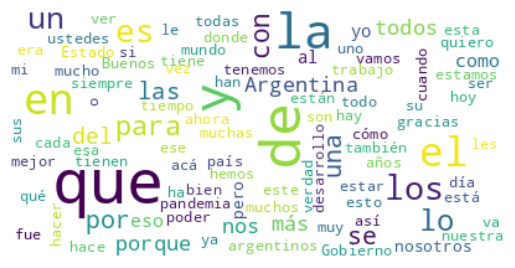

In [77]:
generate_wordcloud(df_af["speech"])

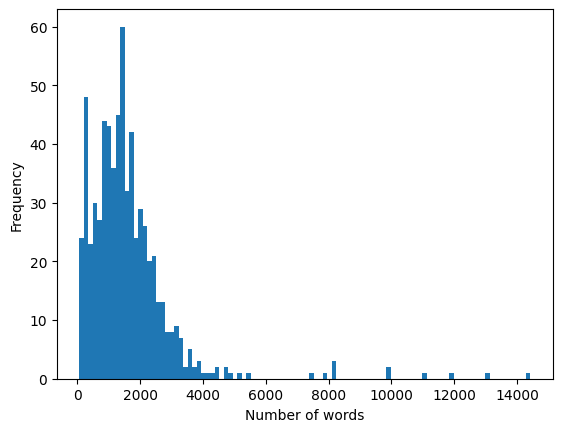

In [78]:
df_af["speech_length"].plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [79]:
df_af["speech_length"].describe()

count      665.000000
mean      1623.535338
std       1446.114435
min         73.000000
25%        859.000000
50%       1396.000000
75%       2030.000000
max      14422.000000
Name: speech_length, dtype: float64

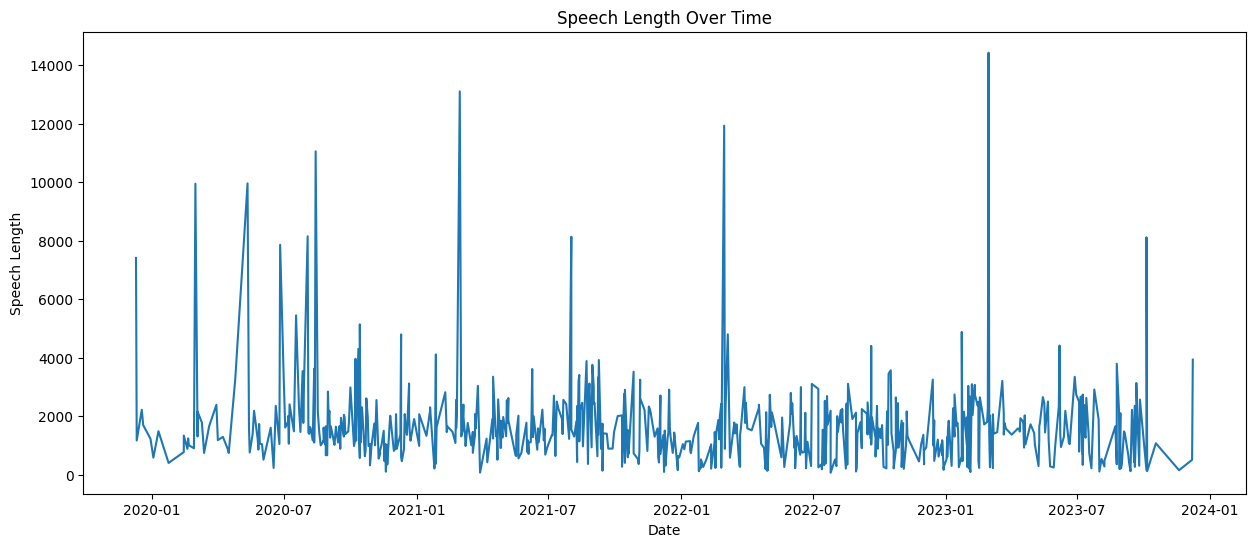

In [80]:
plt.figure(figsize=(15, 6))  # Adjust the width by changing the '15' value

plt.plot(df_af["date"], df_af["speech_length"])
plt.xlabel("Date")
plt.ylabel("Speech Length")
plt.title("Speech Length Over Time")
plt.show()

### Tópicos Principales

Latent Dirichlet Allocation (LDA) es un modelo probabilístico generativo para colecciones discretas de dato como por ejemplo cuerpos de texto.

Es un modelo de jerarquía Bayesiana para modelar automáticamente tópicos extraídos en un corpus. En este modelo, las observaciones (por ejemplo, palabras) son recopiladas en documentos, y la presencia de cada palabra se atribuye cada uno de los temas del documento. Cada documento contendrá reducido de temas.

Gráficamente:

![Colegio Bourbaki](./Images/LDA_graph.png)

Representación Gráfica del Modelo: 

* **β** siendo la distribución de palabras en cada tópico, 

* **θ** la distribución de tópicos en cada discurso, 

* **M** cuerpo total de texto, 

* **N** discurso, 

* **z** y **w** tópicos y palabras

Analíticamente:

![Colegio Bourbaki](./Images/LDA_equation.png)

Podemos ver el resultado con un ejemplo:

![Colegio Bourbaki](./Images/LDA_example.png)

#### Vectorización de textos

In [81]:
df_af["summary"] = df_af["speech"].apply(preprocesar)
df_af["summary_length"] = df_af["summary"].str.split().str.len()

In [82]:
df_af.head()

,speech,date,speech_length,summary,summary_length
451,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411,señora vicepresidente diputadas diputados sena...,3135
306,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174,noches argentina linda noche ustedes cuánto qu...,373
271,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223,días tardes mediodía gracias invitación oportu...,756
154,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696,protocolo romperlo diputados dejaron dormir no...,541
617,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233,gracias empezar pedirle disculpas tardé argent...,456


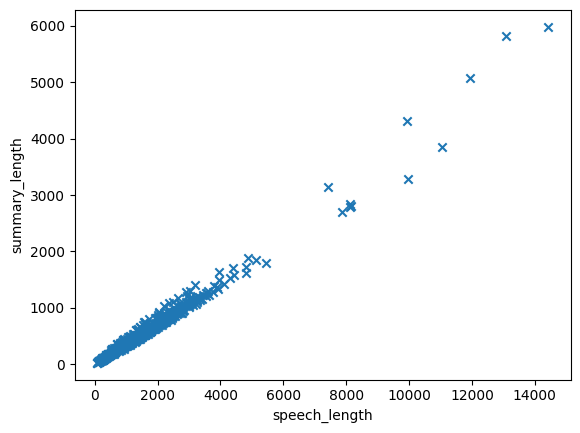

In [83]:
plt.scatter(df_af["speech_length"], df_af["summary_length"], marker="x")
plt.xlabel("speech_length")
plt.ylabel("summary_length")
plt.show()

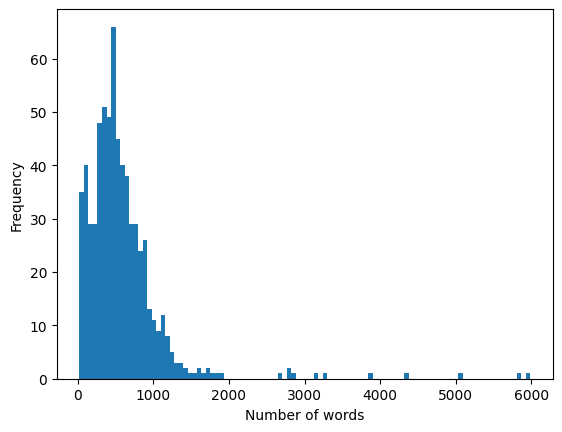

In [84]:
df_af["summary_length"].plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [86]:
df_af["summary_length"].describe()

count     665.000000
mean      589.777444
std       560.065381
min        24.000000
25%       302.000000
50%       487.000000
75%       739.000000
max      5985.000000
Name: summary_length, dtype: float64

In [87]:
summaries = " ".join(df_af["summary"][i] for i in range(len(df_af)))

print(f"Total words in speech: {len(summaries.split())}")
words_summaries = Counter(summaries.split())
words_summaries.most_common(10)

Total words in speech: 392202


[('argentina', 6986),
 ('gracias', 2754),
 ('país', 2455),
 ('mundo', 2295),
 ('argentinos', 2091),
 ('años', 2068),
 ('día', 1982),
 ('pandemia', 1815),
 ('ustedes', 1615),
 ('quiero', 1344)]

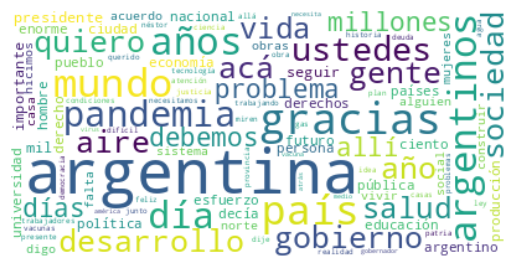

In [88]:
generate_wordcloud(df_af["summary"])

In [150]:
vectorizer = CountVectorizer(min_df = 0.05, max_df = 0.5, ngram_range=(1,3))

En el CountVectorizer de scikit-learn, min_df y max_df son parámetros que controlan el rango de frecuencia de documentos para los términos (palabras o n-gramas) incluidos en el vocabulario. Aquí te explico qué significa cada parámetro:

* **min_df (frecuencia mínima de documentos):**
        Representa el número mínimo de documentos en los que un término (palabra o n-grama) debe aparecer para ser incluido en el vocabulario.
        Si un término aparece en menos documentos que el valor especificado en min_df, se excluye del vocabulario.
        Este parámetro ayuda a filtrar términos que ocurren con muy poca frecuencia y que podrían considerarse ruido o valores atípicos.

* **max_df (frecuencia máxima de documentos):**
        Representa la proporción máxima de documentos en los que un término puede aparecer para ser incluido en el vocabulario.
        Si un término aparece en más documentos que la proporción especificada en max_df, se excluye del vocabulario.
        Este parámetro ayuda a filtrar términos que son demasiado comunes y que pueden no proporcionar información útil.

In [151]:
BOW = vectorizer.fit_transform(df_af["summary"])
BOW.shape

(665, 1688)

In [152]:
vocabulario = vectorizer.get_feature_names_out()
len(vocabulario)

1688

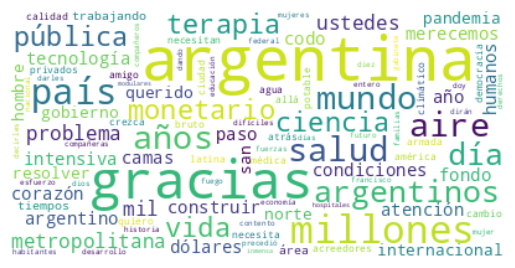

In [153]:
generate_wordcloud(vocabulario)

### Entrenamiento del modelo

El número óptimo de topicos depende de las caracteristicas del texto a analizar (el largo de los textos, la cantidad de distintas ideas)

No obstante existen algunas metricas que ayudan a determinar k.

In [154]:
k = 4

In [155]:
lda_model = LatentDirichletAllocation(
    n_components=k,
    learning_method="online",
    max_iter=1000,
    random_state=42,
)

In [156]:
%%time
lda_model.fit(BOW)  # entrena el modelo y obtiene la matriz documento-topico

CPU times: user 5min 23s, sys: 103 ms, total: 5min 23s
Wall time: 5min 24s


LatentDirichletAllocation(learning_method='online', max_iter=1000,
                          n_components=4, random_state=42)

### Distribución de temas en cada noticia  ($\theta$)

In [157]:
doc_top = pd.DataFrame(lda_model.transform(BOW))
print(doc_top.shape)
doc_top.head()

(665, 4)


,0,1,2,3
0,0.097032,0.089337,0.813458,0.000173
1,0.459416,0.387334,0.151943,0.001308
2,0.089714,0.495522,0.277258,0.137506
3,0.513943,0.000852,0.173103,0.312102
4,0.888500,0.108440,0.001499,0.001560


In [158]:
doc_top.sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
660    1.0
661    1.0
662    1.0
663    1.0
664    1.0
Length: 665, dtype: float64

In [159]:
df_lda = pd.merge(df_af, doc_top, left_index=True, right_index=True)
df_lda.head()

,speech,date,speech_length,summary,summary_length,0,1,2,3
451,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411,señora vicepresidente diputadas diputados sena...,3135,0.096958,0.311764,0.590662,0.000616
306,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174,noches argentina linda noche ustedes cuánto qu...,373,0.047460,0.809724,0.054593,0.088223
271,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223,días tardes mediodía gracias invitación oportu...,756,0.000387,0.784439,0.016304,0.198870
154,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696,protocolo romperlo diputados dejaron dormir no...,541,0.305761,0.224714,0.000714,0.468811
617,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233,gracias empezar pedirle disculpas tardé argent...,456,0.312477,0.000575,0.686375,0.000573


### Distribución de palabras en cada tema ($\mu$)

In [160]:
μs = pd.DataFrame(lda_model.exp_dirichlet_component_, columns=vocabulario)
print(μs.shape)
μs

(4, 1688)


,abajo,abogado,abrazo,abrir,absoluta,absolutamente,acaba,acabo,acceder,acceso,...,zona,área,área metropolitana,área metropolitana aire,época,ética,ético,íbamos,única,único
0,3.786979e-07,8.534561e-04,0.000752,0.000432,0.000099,0.001142,0.000595,0.000584,0.000967,0.000657,...,0.000329,2.374386e-06,2.838253e-07,2.851675e-07,6.318979e-04,0.000244,0.000299,2.588219e-04,0.000266,0.002479
1,4.286167e-04,3.263501e-04,0.000616,0.000289,0.000117,0.000776,0.000181,0.000023,0.001799,0.000311,...,0.000442,2.524977e-07,2.447213e-07,2.172266e-07,1.751261e-04,0.000180,0.000137,1.084459e-03,0.001176,0.001927
2,1.170893e-04,3.848361e-07,0.000103,0.000042,0.000600,0.000352,0.000240,0.000110,0.000345,0.001554,...,0.000569,5.002113e-04,2.167485e-06,2.900679e-07,3.196245e-04,0.000562,0.000351,3.553141e-07,0.000164,0.000345
3,5.222073e-04,4.391829e-04,0.000472,0.000627,0.000278,0.001249,0.000118,0.000316,0.000788,0.000369,...,0.002521,3.131576e-03,3.030117e-03,2.183579e-03,4.715069e-07,0.000963,0.000709,4.304237e-04,0.001325,0.002084



Palabras más frecuentes del topico 0
['universidad', 'hombre', 'educación', 'mujeres', 'derechos', 'pueblo', 'derecho', 'futuro', 'democracia', 'tecnología']


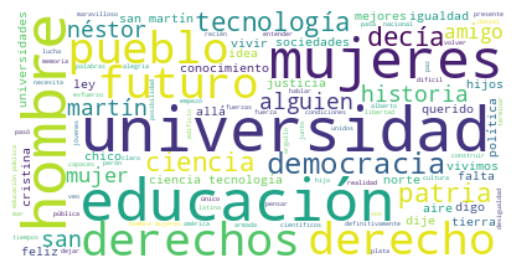


Palabras más frecuentes del topico 1
['mil', 'pública', 'obra', 'obras', 'hicimos', 'agua', 'millones', 'casa', 'casas', 'ciento']


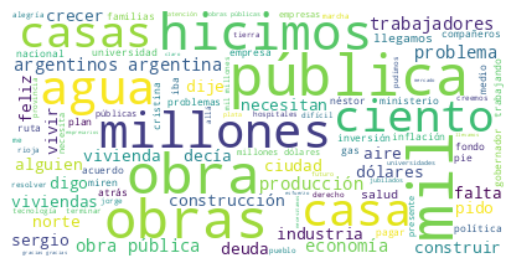


Palabras más frecuentes del topico 2
['países', 'millones', 'social', 'crisis', 'internacional', 'producción', 'nacional', 'sistema', 'economía', 'ley']


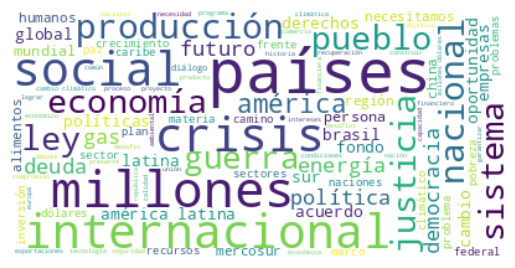


Palabras más frecuentes del topico 3
['salud', 'aire', 'problema', 'virus', 'persona', 'ciudad', 'provincia', 'sistema', 'vacuna', 'vacunas']


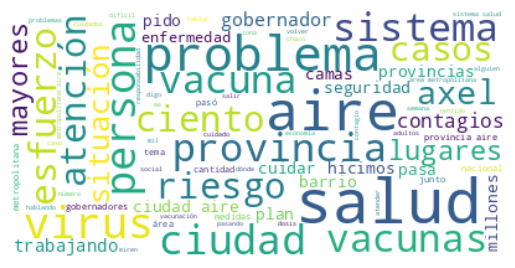

In [161]:
for top in range(k):
    print(f"\nPalabras más frecuentes del topico {top}")
    words = list(μs.T[top].sort_values(ascending=False).head(10).index)
    freq = μs.T[top].sort_values(ascending=False).head(100)
    print(words)
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        normalize_plurals=False,
        collocations=False,
    ).generate_from_frequencies(freq)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Visualización del modelo

In [162]:
pyLDAvis.lda_model.prepare(lda_model, BOW, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.100091 -0.026758       1        1  31.947705
0     -0.029072 -0.128236       2        1  26.690377
2      0.195325  0.014718       3        1  22.193152
3     -0.066163  0.140276       4        1  19.168766, topic_info=            Term         Freq        Total Category  logprob  loglift
1429       salud  1165.000000  1165.000000  Default  30.0000  30.0000
39          aire  1193.000000  1193.000000  Default  29.0000  29.0000
1063        obra   666.000000   666.000000  Default  28.0000  28.0000
1643       virus   415.000000   415.000000  Default  27.0000  27.0000
1125      países   812.000000   812.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1572  trabajando   174.123766   499.668267   Topic4  -5.5212   0.5977
1108        pasa   157.577449   355.894141   Topic4  -5.6211   0.8372
968     millones   161.929816  1061.008896   Topic4  -5.5938  -0.2279
1170        pido   154.337891   443.921124   Topic4  -5.6419   0.5954
735      hicimos   153.526178   722.568942   Topic4  -5.6471   0.1029

[289 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
25        1  0.326409                  acuerdo
25        2  0.164096                  acuerdo
25        3  0.353164                  acuerdo
25        4  0.155178                  acuerdo
29        4  0.996442                  adultos
...     ...       ...                      ...
1679      2  0.006124                     área
1679      3  0.159229                     área
1679      4  0.839016                     área
1680      4  0.989654       área metropolitana
1681      4  0.996537  área metropolitana aire

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

Ejercicios:

1) Conceptos Básicos:
* ¿Cómo describirías en términos generales qué es el Modelado de Asociación Latente (LDA)?
        
* Explique el concepto de "temas" en el contexto de LDA.
        
* ¿Cuál es el objetivo principal de LDA en el procesamiento de lenguaje natural?

2) Proceso de LDA:
* Describe los pasos fundamentales en el proceso de aplicar LDA a un conjunto de documentos.
        
* ¿Qué representa la distribución de tópicos en un documento según LDA?

3) Parámetros y Ajuste:
* ¿Qué papel juegan los parámetros alpha y beta en el modelo LDA?
        
* ¿Cómo afecta el número de tópicos elegido al resultado del modelado LDA?

4) Aplicaciones Prácticas:
* Proporciona ejemplos de situaciones del mundo real donde el modelado LDA podría ser útil.
        
* ¿Cómo podría LDA ser utilizado para descubrir patrones en grandes conjuntos de documentos?

5) Desafíos y Limitaciones:
* ¿Cuáles son algunos desafíos comunes al aplicar LDA en el procesamiento de lenguaje natural?
        
* ¿Puedes mencionar algunas limitaciones de LDA y cómo podrían abordarse?

6) Comparación con Otros Modelos:
* ¿Cómo se compara LDA con otros enfoques de modelado de tópicos en el procesamiento de lenguaje natural? (Si es que conocen alguno)

7) **Realizar el mismo procedimiento para los discursos presidenciales del ex Presidente Mauricio Macri** (IMPORTANTE PARA COMPRENDER EL FLUJO DE TRABAJO)

8) **Como vimos usamos BoW para vectorizar el texto, podriamos usar TD-IDF? Explique. Obtendriamos mejores agrupaciones?**

9) **Evaluar el modelo con múltiples ejecuciones:** LDA utiliza una inicialización aleatoria para los parámetros del modelo. Esto significa que, incluso con la misma configuración y datos, los resultados pueden variar debido a diferentes semillas aleatorias. Si la variabilidad sigue siendo un problema, se podría realizar múltiples ejecuciones del modelo y promediar o analizar los resultados para obtener una visión más estable.

Si les interesa guardar el modelo:

In [163]:
# import pickle
# path = ''
# tuple_models = (lda_model, BOW, vectorizer)
# pickle.dump(tuple_models, open (path + "model.pkl", 'wb'))

In [164]:
# import pickle
# path = ''
# lda_model, BOW, vectorizer = pickle.load(open(path + "tuple_model_books_k10.pkl", 'rb'))

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)